### Currency

USD/KRW, USD/JPY

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

start_date = '2014-01-01'
end_date = '2024-03-25'

stock_tickers = ['KRW=X','JPY=X']
stocks = yf.download(tickers = stock_tickers, start = start_date, end = end_date)['Adj Close']

[*********************100%%**********************]  2 of 2 completed


In [2]:
stocks

Ticker,JPY=X,KRW=X
Date,,
2014-01-01,105.300003,1054.800049
2014-01-02,105.323997,1050.750000
2014-01-03,104.833000,1049.599976
2014-01-06,104.912003,1053.800049
2014-01-07,104.209999,1065.400024
...,...,...
2024-03-18,148.955002,1329.339966
2024-03-19,149.143997,1336.089966
2024-03-20,151.035004,1337.020020


In [3]:
stocks_ret = stocks.pct_change()
cumret = ((1 + stocks_ret).cumprod() - 1).fillna(0)

days = [i for i in range(3, 62, 2)]
threshold = tuple([-i * 0.01 for i in range(3, 21)])
items = [(i, j) for i in days for j in threshold]

asset = dict()
for i in cumret.columns :
    asset[i] = pd.DataFrame(index = stocks.index)

for i in cumret.columns :
    for j in range(1, 501) :
        asset[i]['-' + str(j) + 'days'] = (stocks[i] - stocks[i].shift(j)) / stocks[i]

for i in cumret.columns :
    asset[i].to_csv(i + '_returns_data_adj.csv')
    asset[i].to_excel(i + '_returns_data_adj.xlsx')

for i in cumret.columns :
    asset[i].index = range(len(stocks))

In [12]:
from tqdm import tqdm
dataframes = dict()
dataframes_plot = dict()

for asset_index in cumret.columns :
    dataframes[asset_index] = dict()
    dataframes_plot[asset_index] = dict()
    for d, thres in tqdm(items) :
        thres = round(-thres * 100, 1)
        dataframes[asset_index][f'day{d}_{thres}per'] = pd.DataFrame(index = stocks.index)
        dataframes_plot[asset_index][f'day{d}_{thres}per_plot'] = pd.DataFrame(index = stocks.index)
        
        for i in range(1, 501) :
            temp = ((1 + cumret[asset_index].iloc[
                        asset[asset_index][asset[asset_index][str(-i) + 'days'] < -thres * 0.01][:-d].index + d
                    ]) / (1 + cumret[asset_index].iloc[asset[asset_index][asset[asset_index][str(-i) + 'days'] < -thres * 0.01][:-d].index].values)) -1
            dataframes[asset_index][f'day{d}_{thres}per'] = pd.concat(
                    [dataframes[asset_index][f'day{d}_{thres}per'], temp], axis = 1
            )
            dataframes_plot[asset_index][f'day{d}_{thres}per_plot'] = pd.concat(
                [dataframes_plot[asset_index][f'day{d}_{thres}per_plot'], temp], axis = 0
            )
        dataframes[asset_index][f'day{d}_{thres}per'].columns = [str(-i) + 'days' for i in range(1, 501)]
        dataframes[asset_index][f'day{d}_{thres}per'].to_excel(f'./excel/{asset_index}_day{d}_{int(thres)}per.xlsx')

100%|██████████| 540/540 [2:05:04<00:00, 13.90s/it]  


In [18]:
for asset_index in cumret.columns :
    for d, thres in tqdm(items) :
        thres = round(-thres * 100, 1)
        dataframes[asset_index][f'day{d}_{thres}per'].to_parquet(f'./parquet/{asset_index}_day{d}_{int(thres)}per.parquet')

100%|██████████| 540/540 [00:28<00:00, 18.87it/s]


#### 불러오기

In [6]:
from tqdm import tqdm
dataframes = dict()

for asset_index in cumret.columns :
    dataframes[asset_index] = dict()
    for d, thres in tqdm(items) :
        thres = round(-thres * 100, 1)
        dataframes[asset_index][f'day{d}_{thres}per'] = pd.read_excel(f'./excel/{asset_index}_day{d}_{int(thres)}per.xlsx')

100%|██████████| 540/540 [47:20<00:00,  5.26s/it]


#### 분포적 특성확인

In [8]:
def statsplot(index, data, thresh, ticker : str) :
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 2, 1)
    plt.plot(
        index, [i.mean() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-0.05, 0.25])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('mean')
    
    plt.subplot(2, 2, 2)
    plt.plot(
        index, [i.std() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-0.05, 0.2])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('standard dev')
    
    plt.subplot(2, 2, 3)
    plt.plot(
        index, [i.skew() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-1, 1])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('skewness')
    
    plt.subplot(2, 2, 4)
    plt.plot(
        index, [i.kurt() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-1, 2.2])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('kurtosis')
    
    plt.tight_layout()
    
    plt.suptitle(f'sim_thresh : {thresh}% | market : {ticker} | start : {start_date} | end : {end_date}')
    plt.tight_layout()
    
    filename = f'./figure/{ticker}_distribution_{thresh}percent.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return None

def pipeline(threshold, days, dataframes, ticker) :
    values = []

    for i in days :
        values.append(
            dataframes[f"day{i}_{threshold}.0per"].iloc[:,1:].stack().reset_index(drop=True)
        )
    
    statsplot(days, values, threshold, ticker)
    return None

In [9]:
cumret.columns

Index(['JPY=X', 'KRW=X'], dtype='object', name='Ticker')

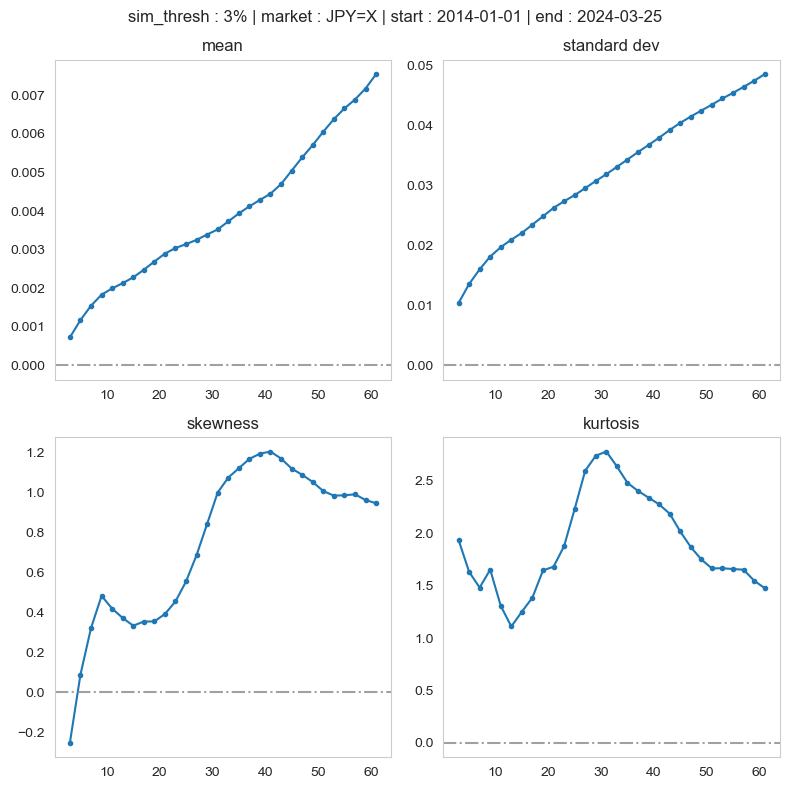

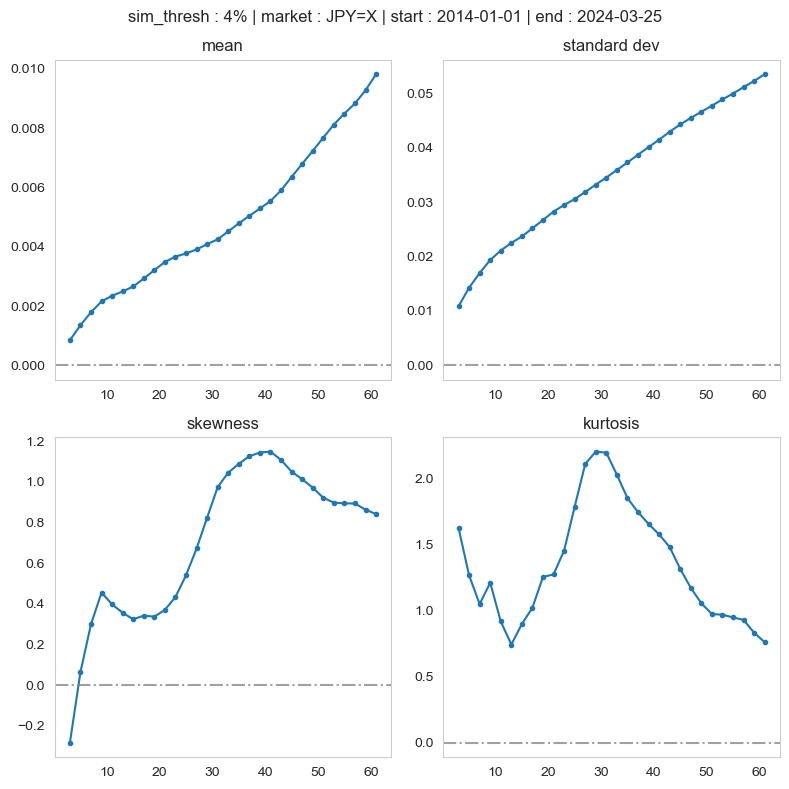

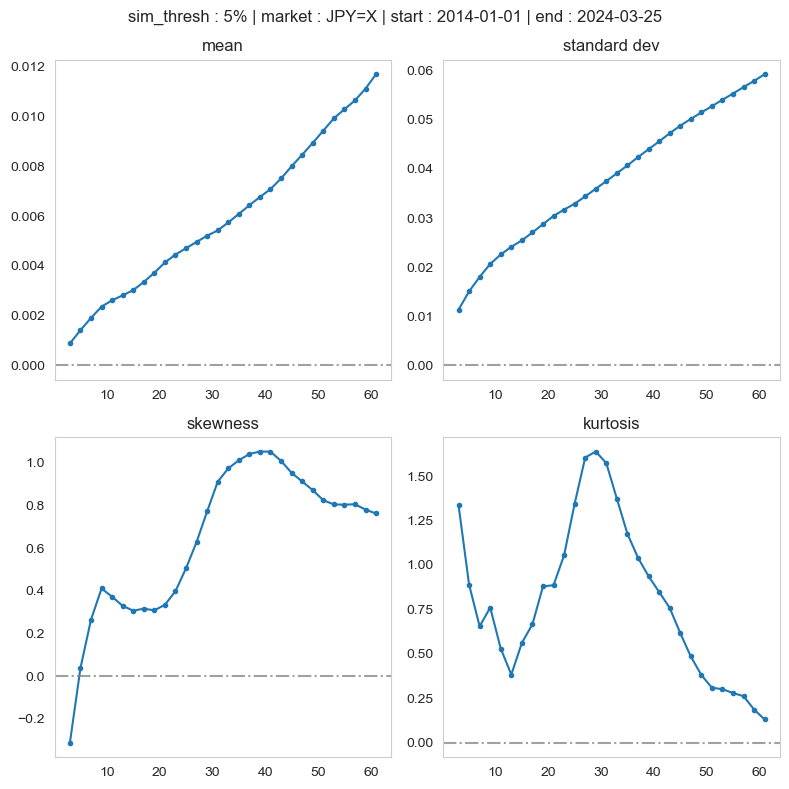

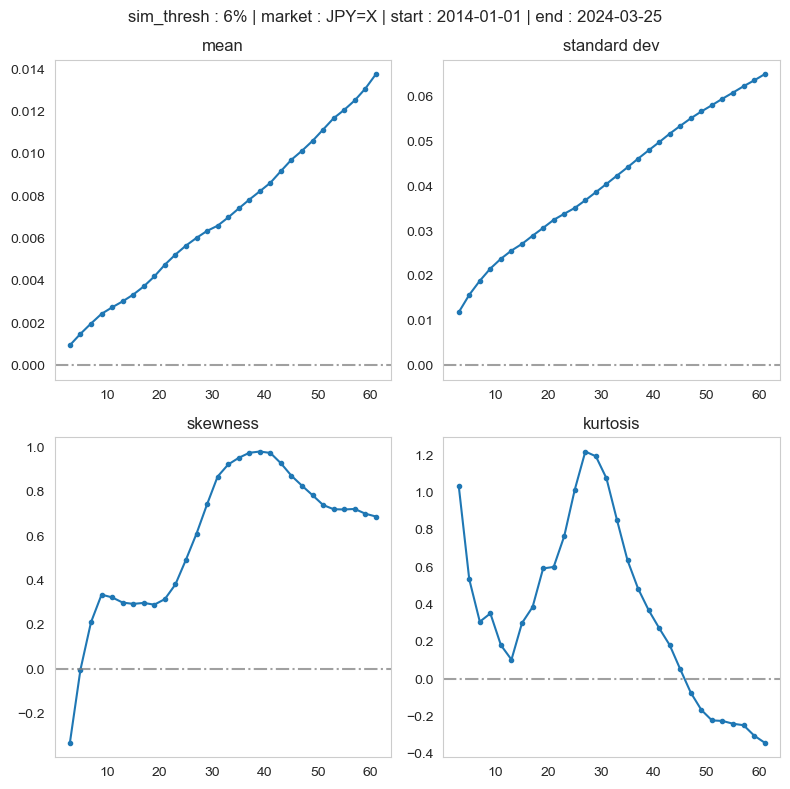

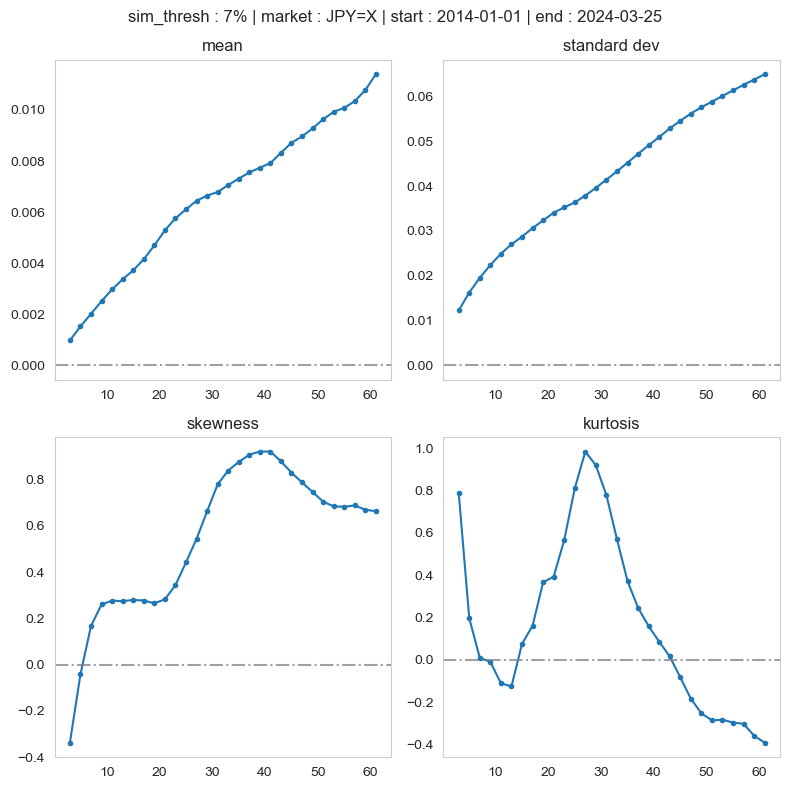

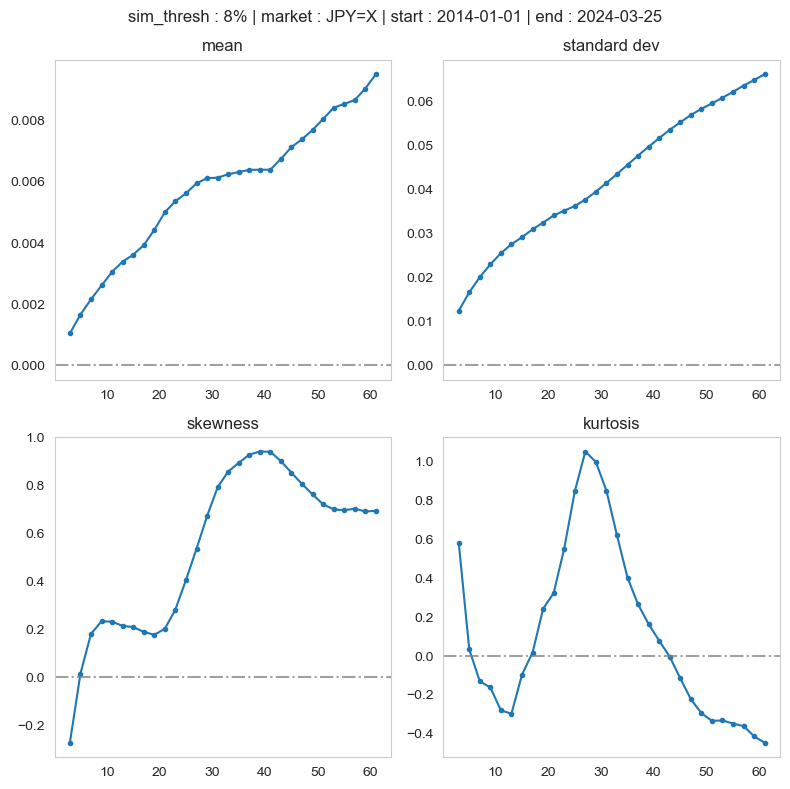

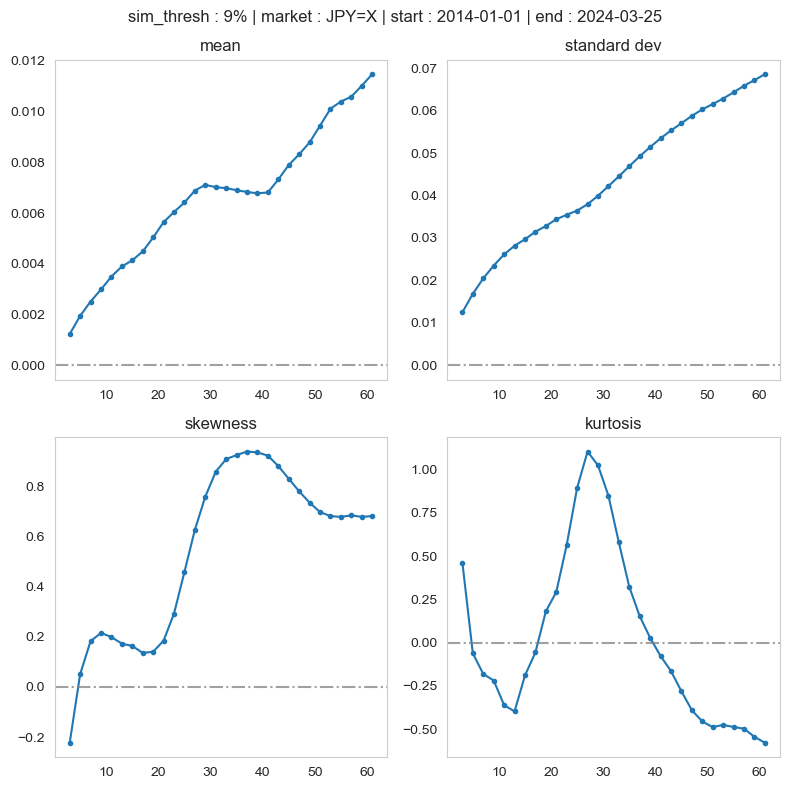

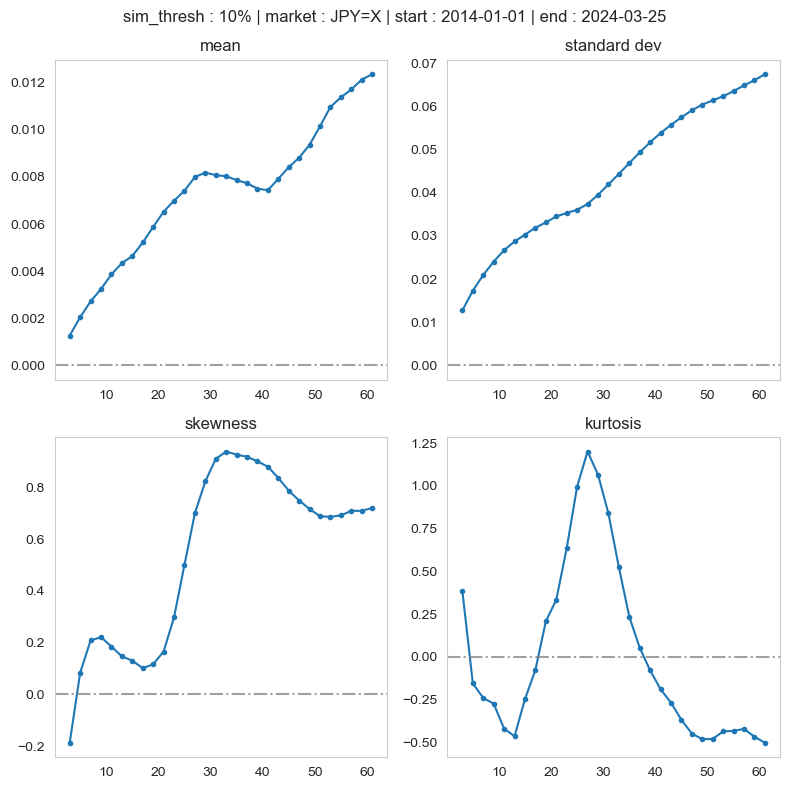

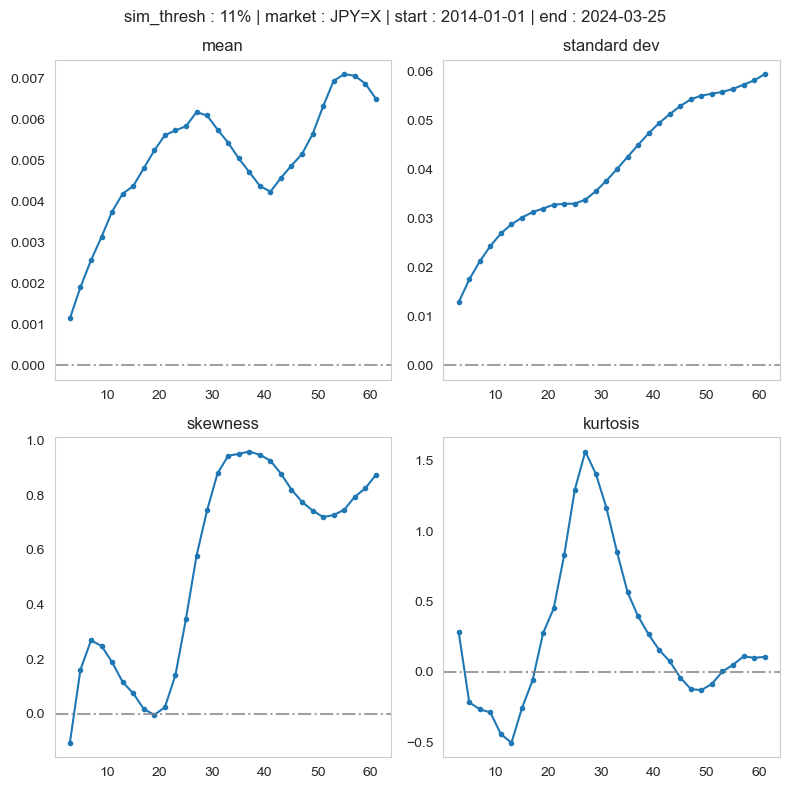

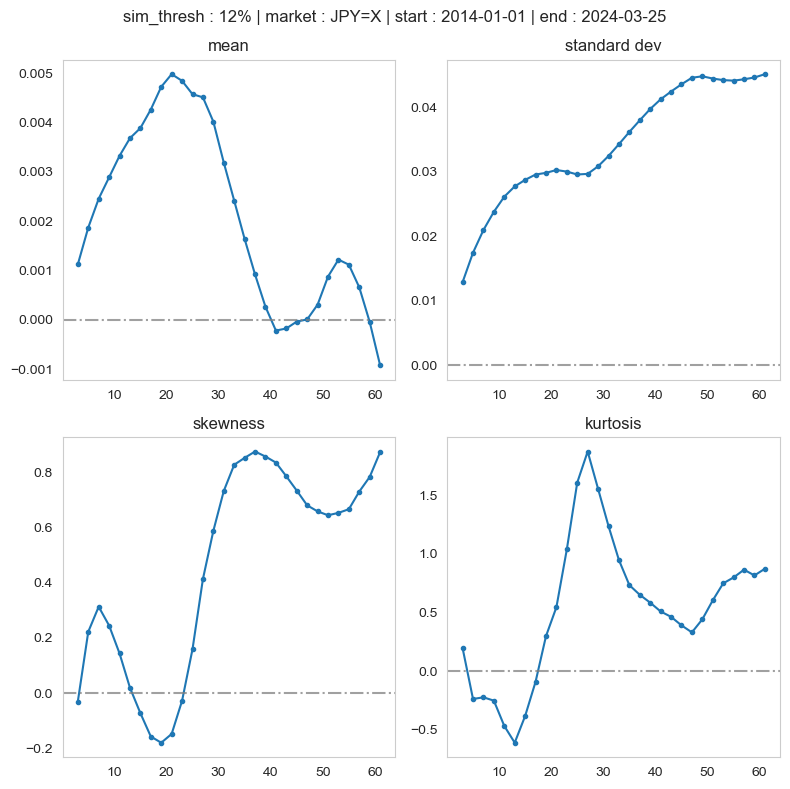

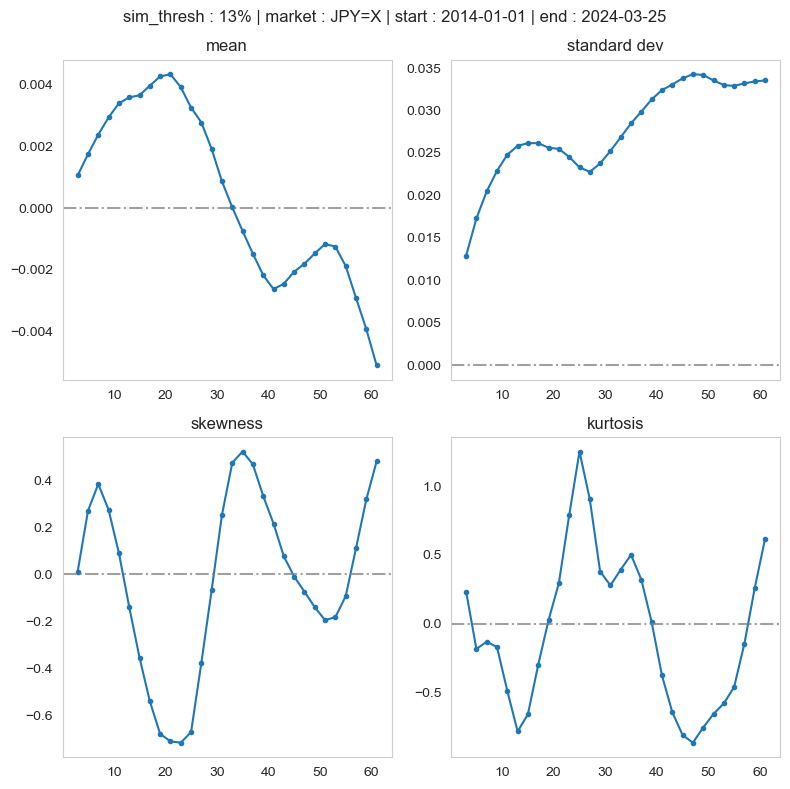

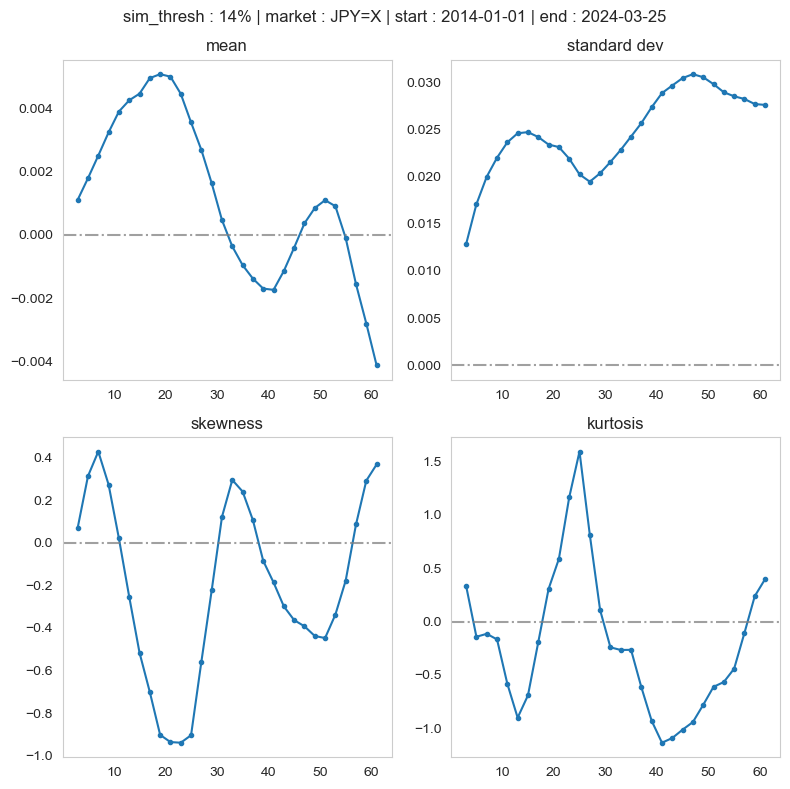

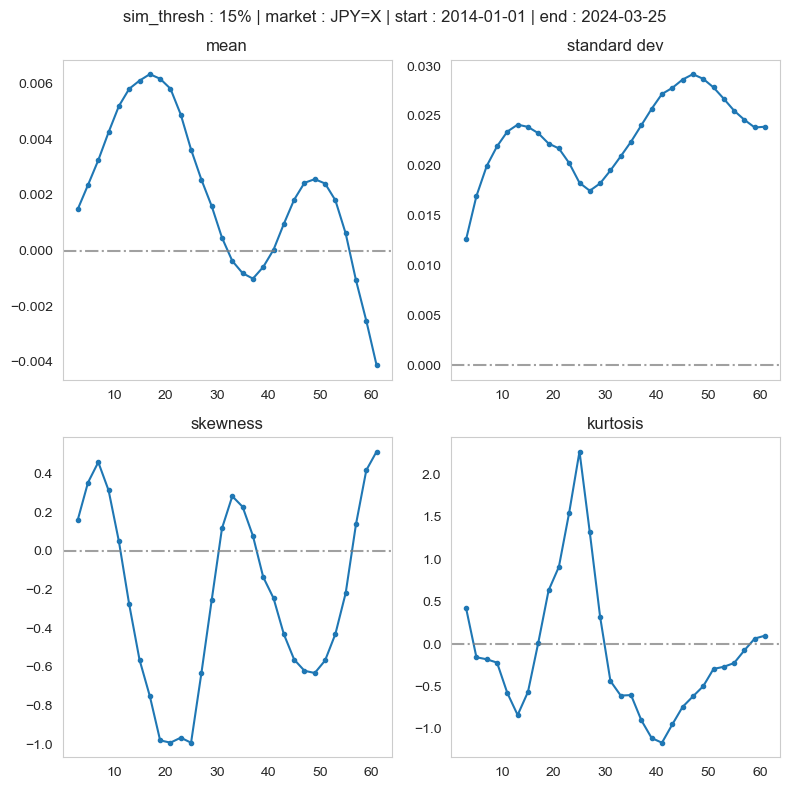

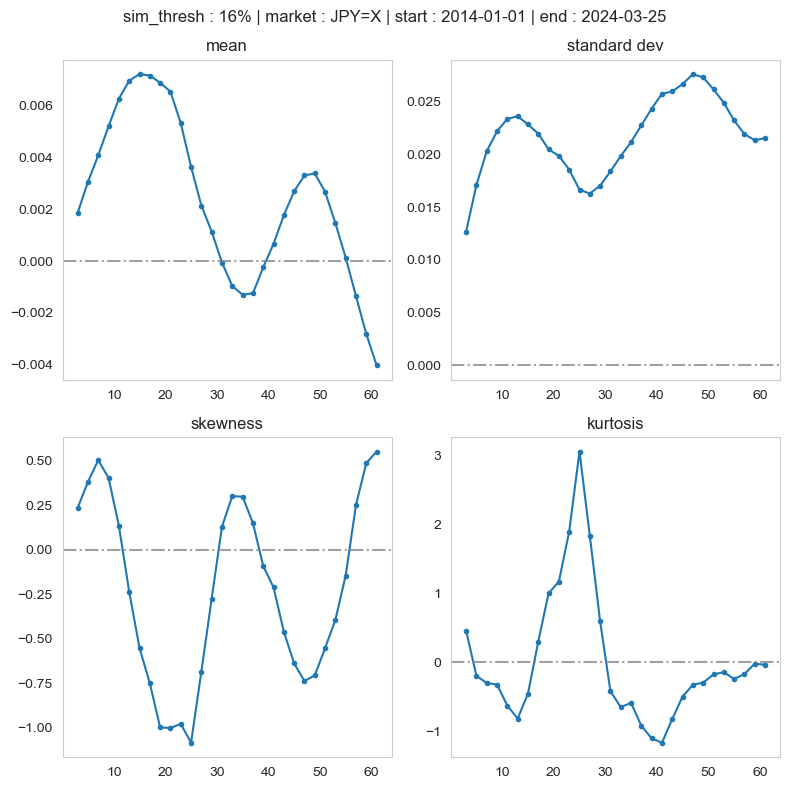

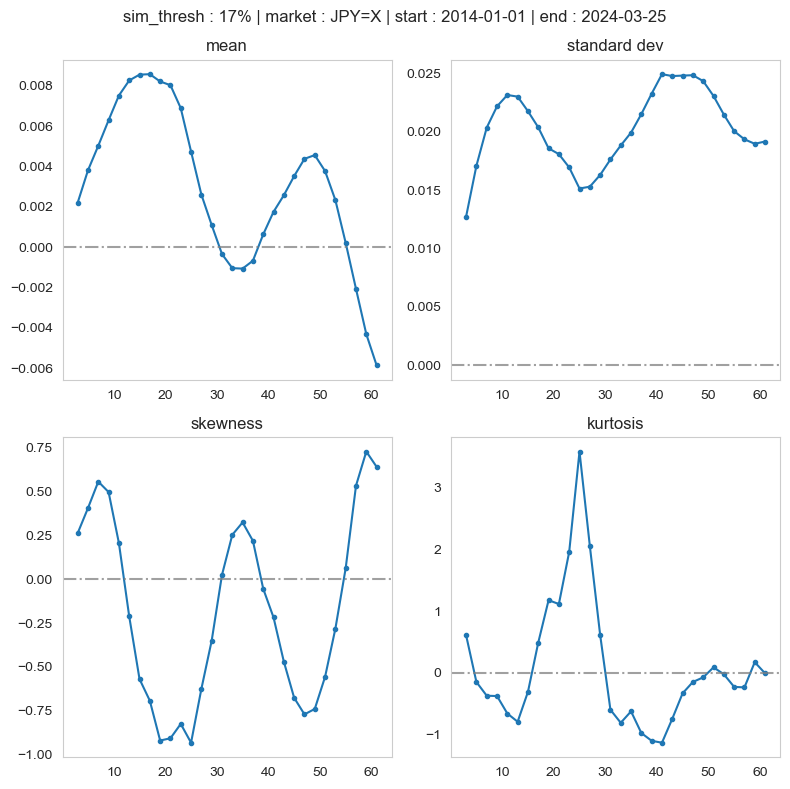

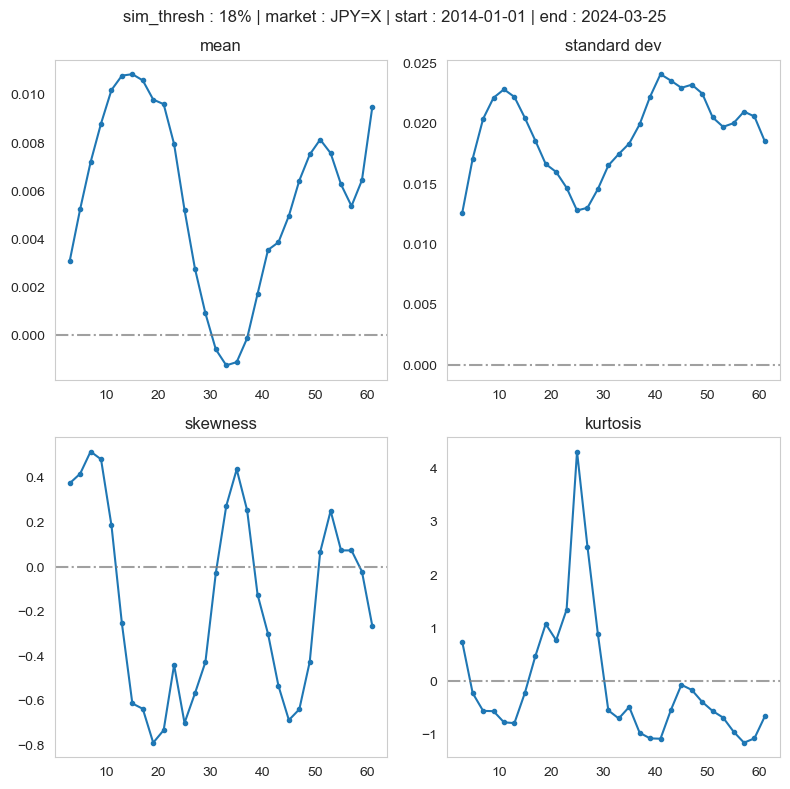

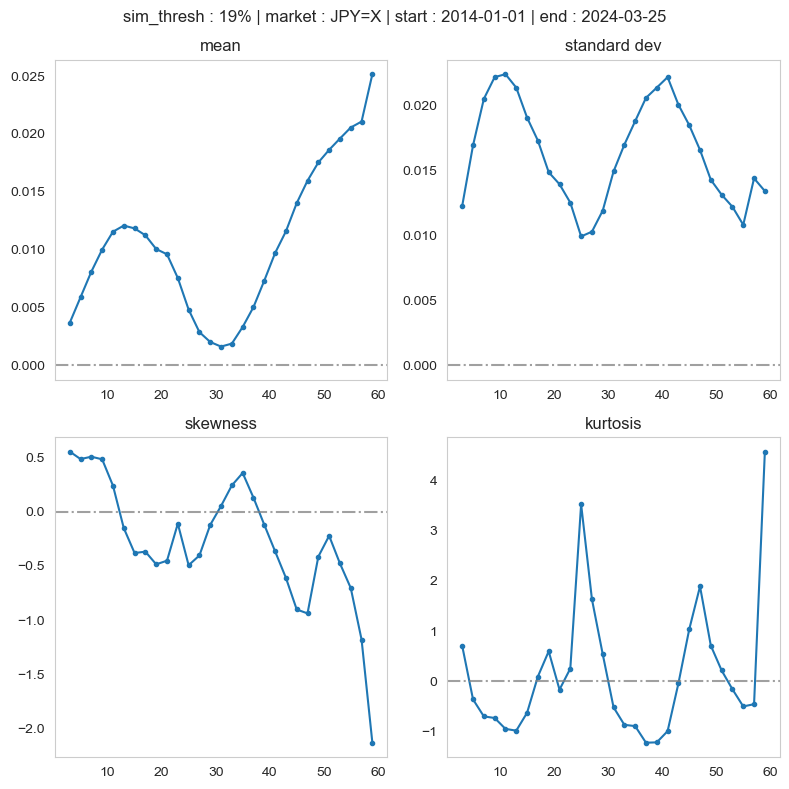

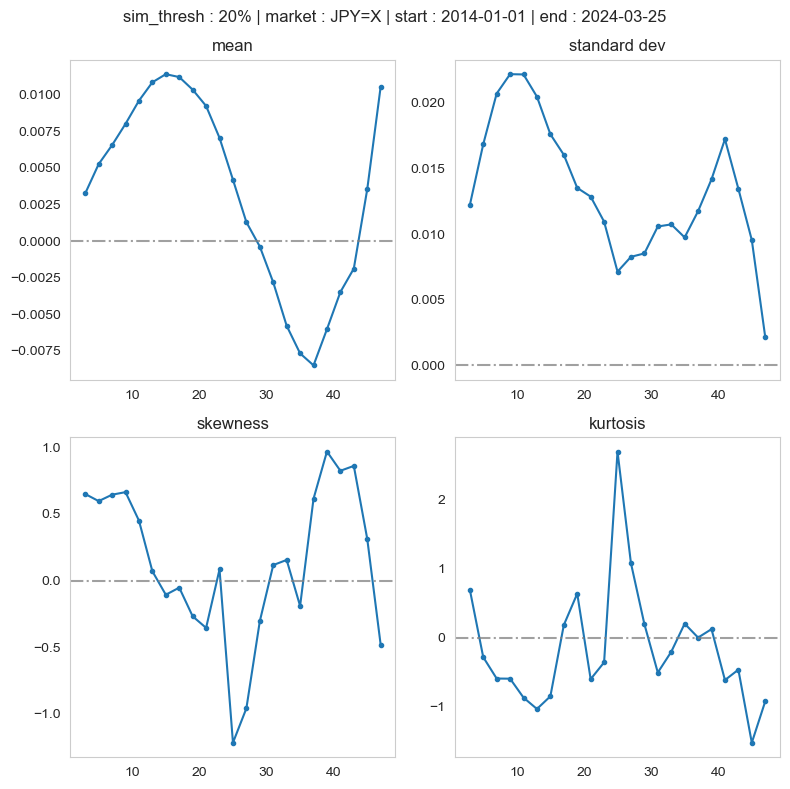

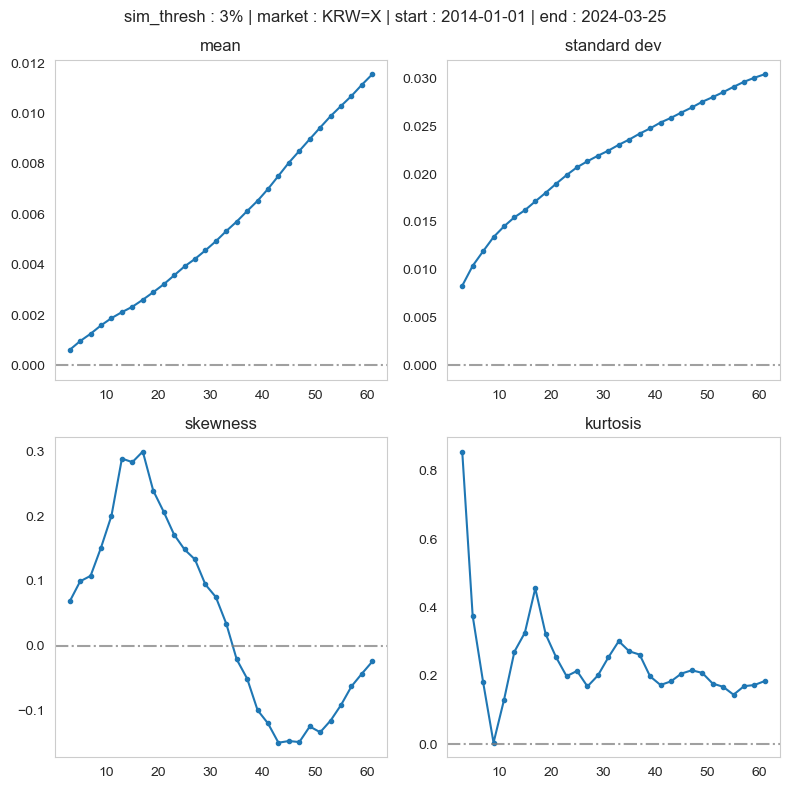

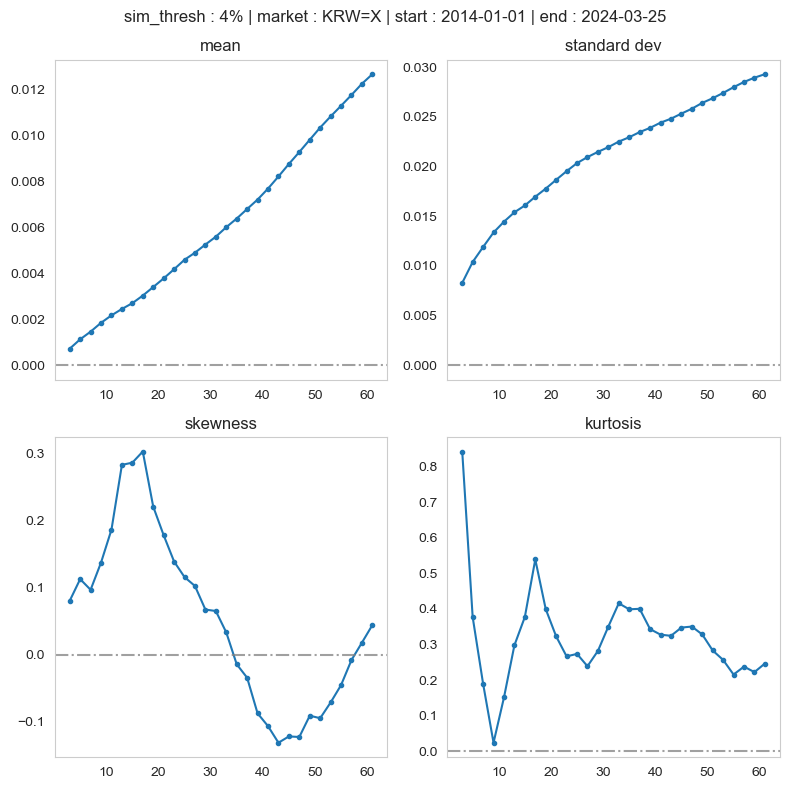

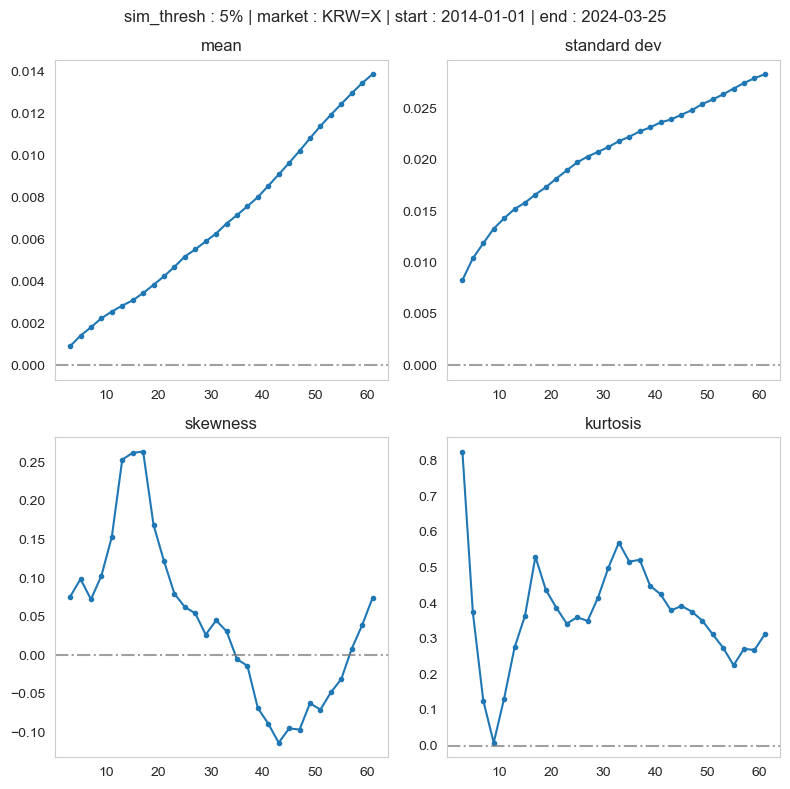

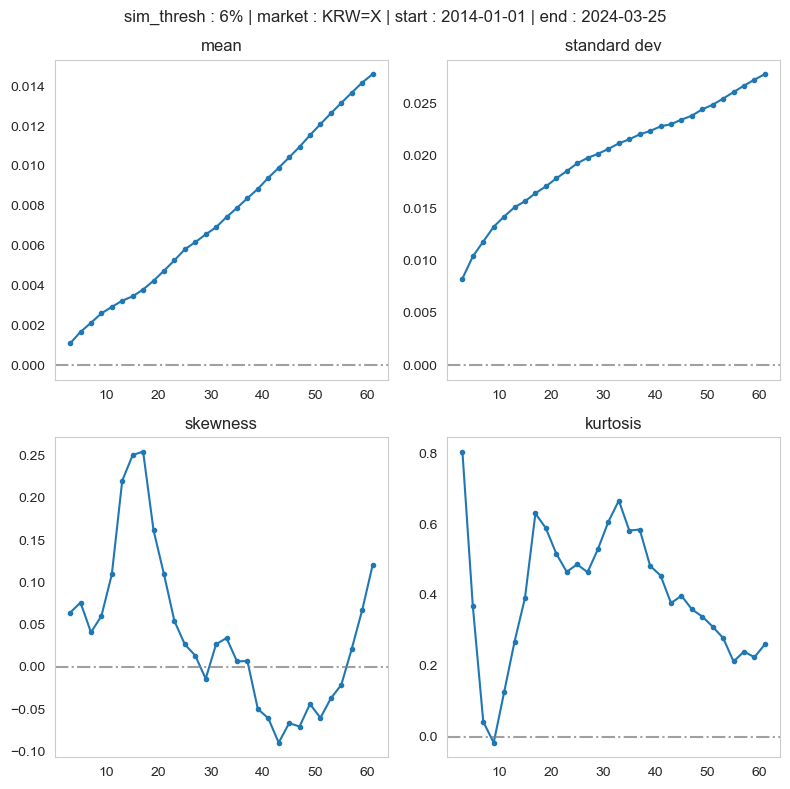

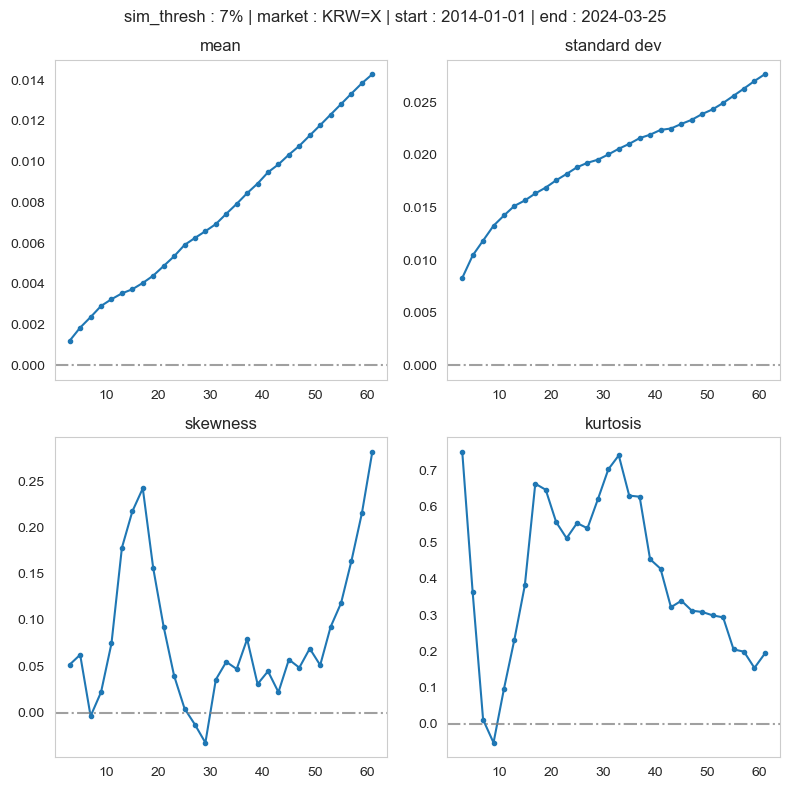

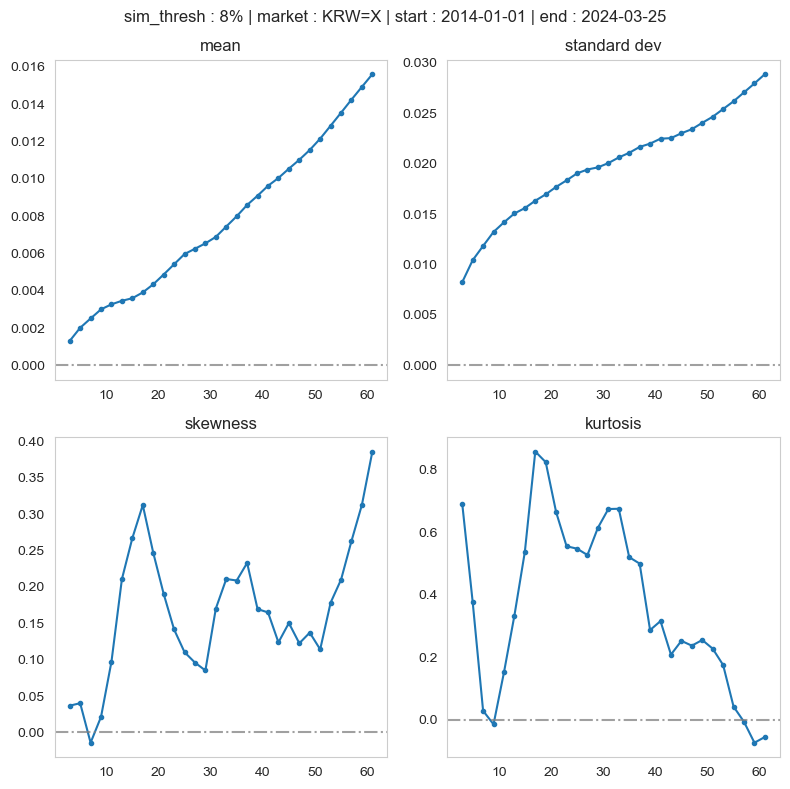

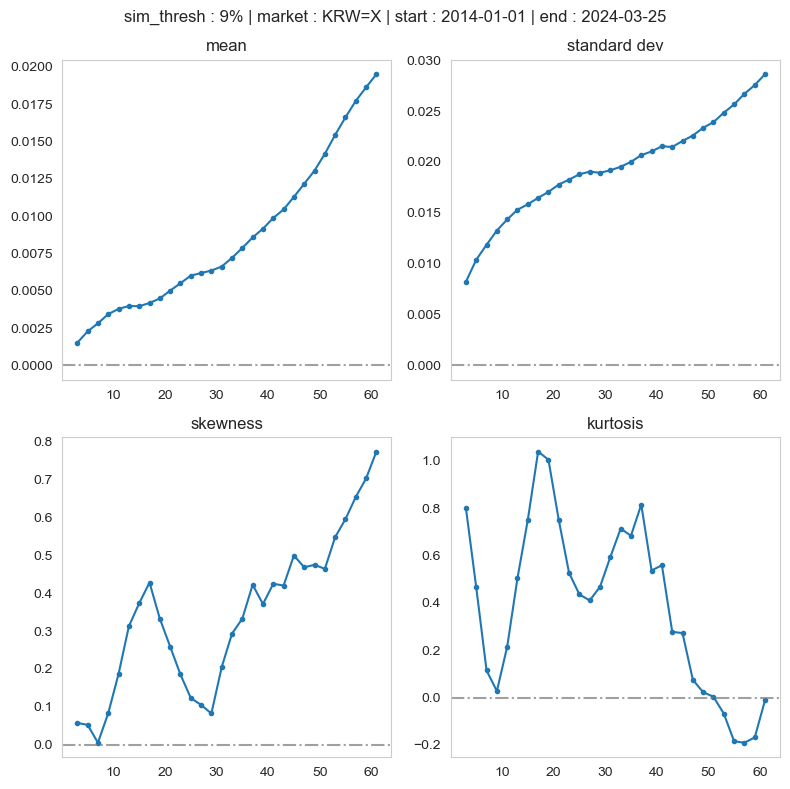

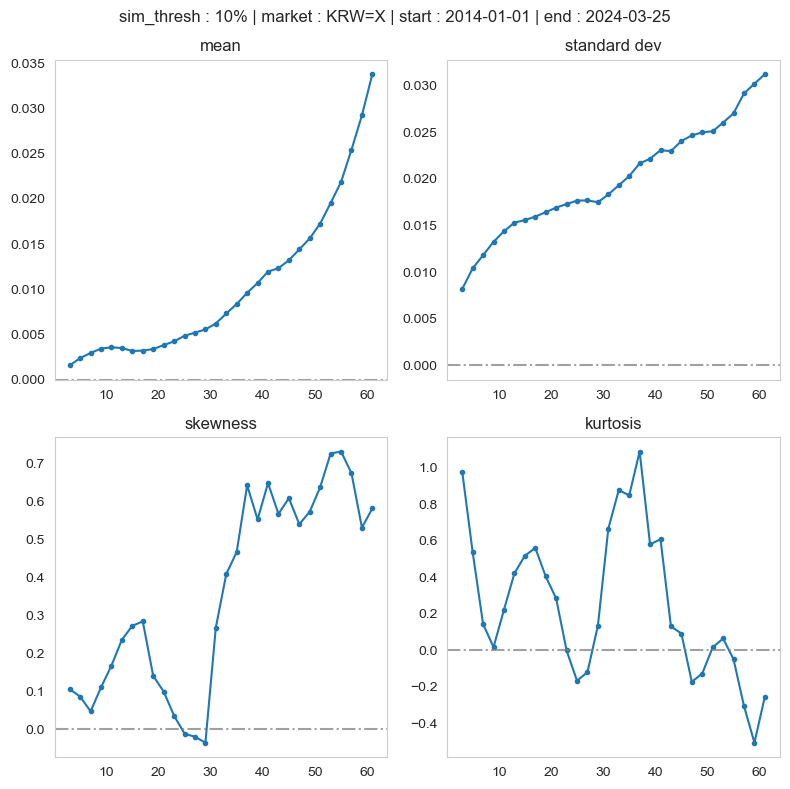

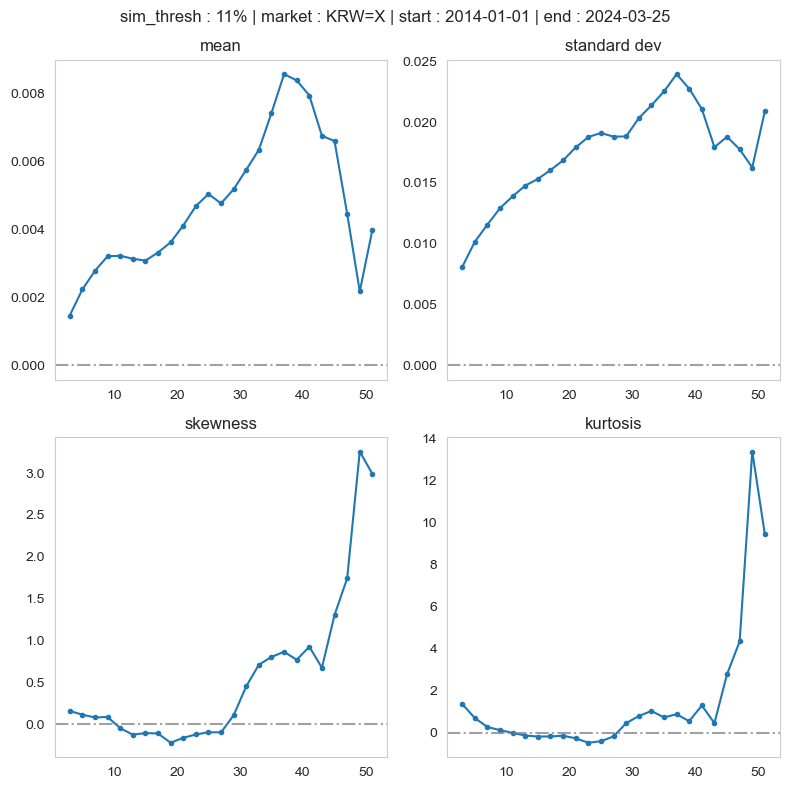

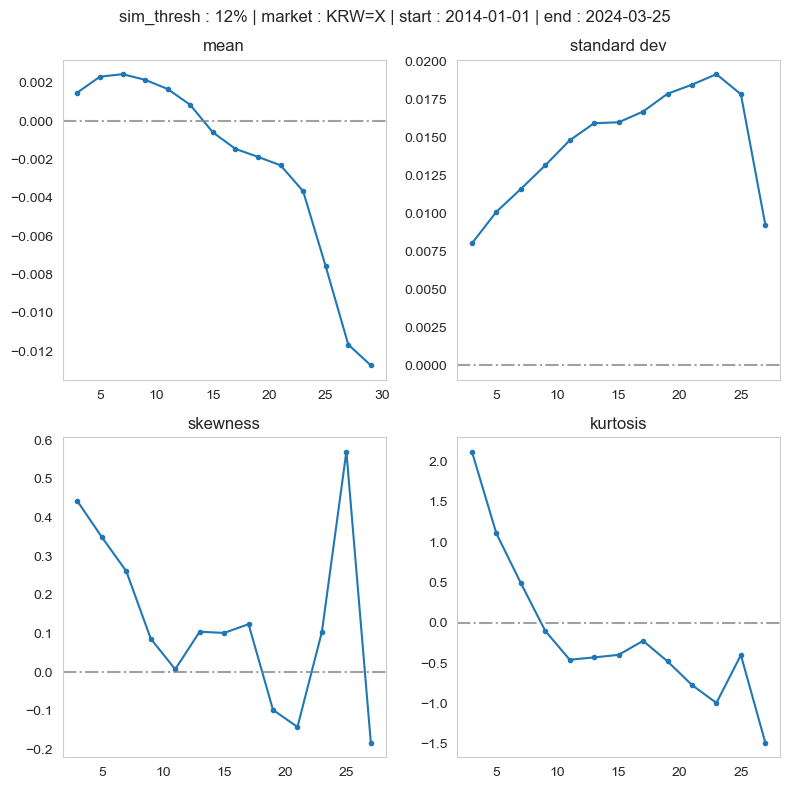

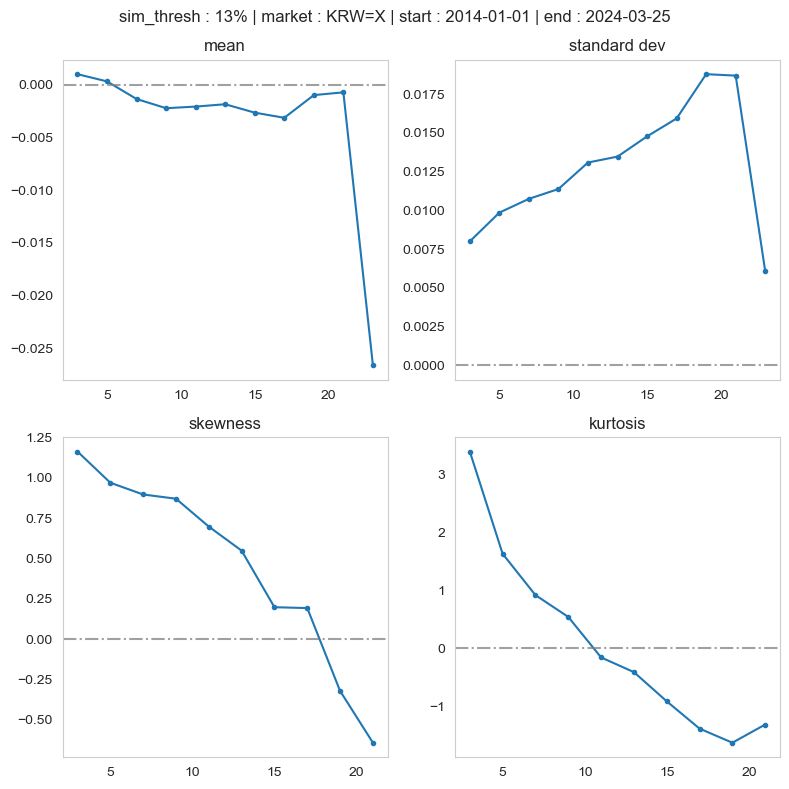

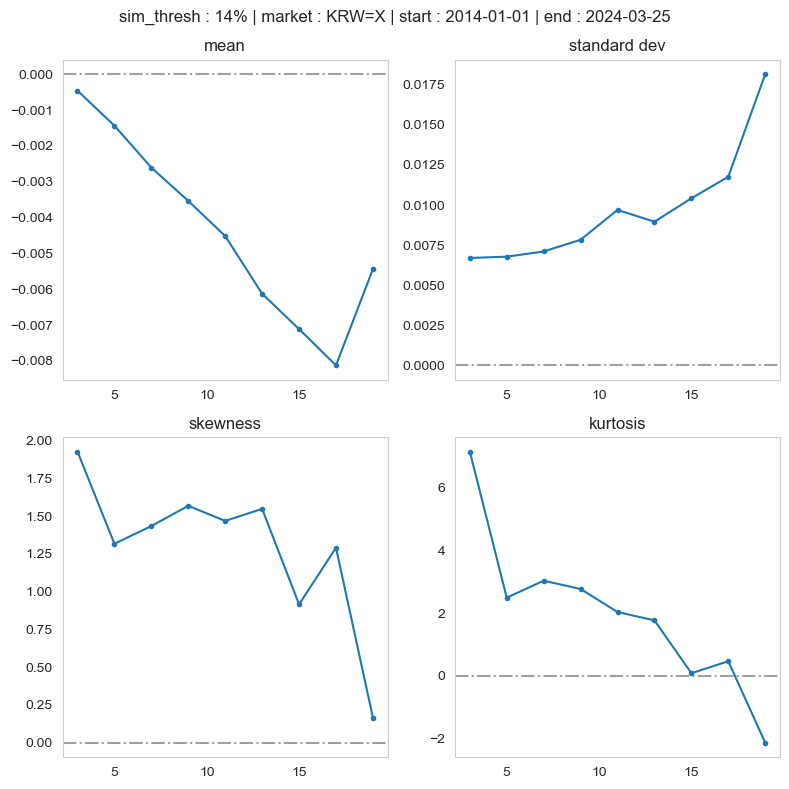

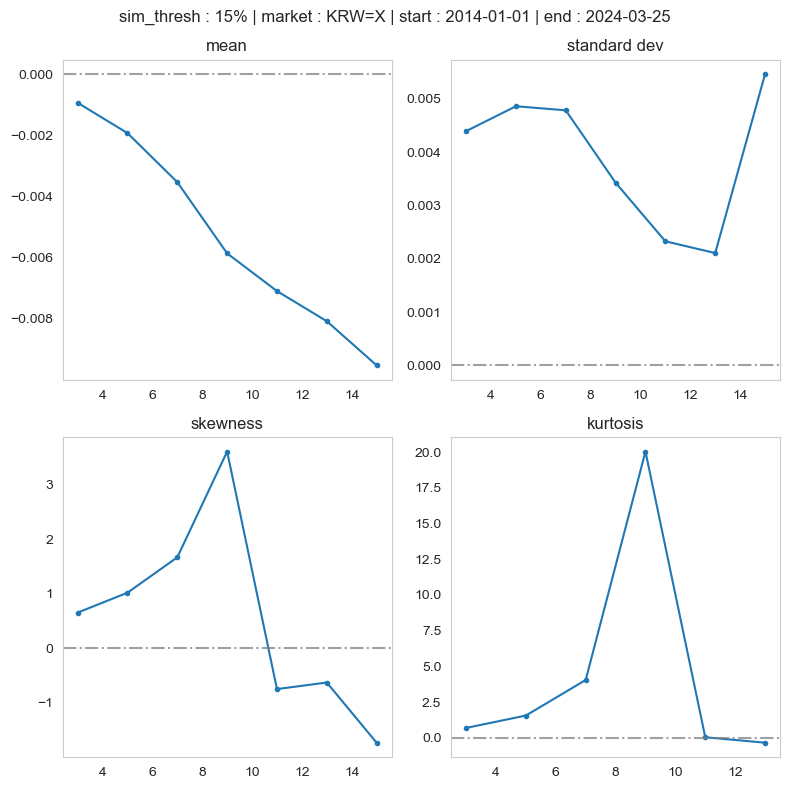

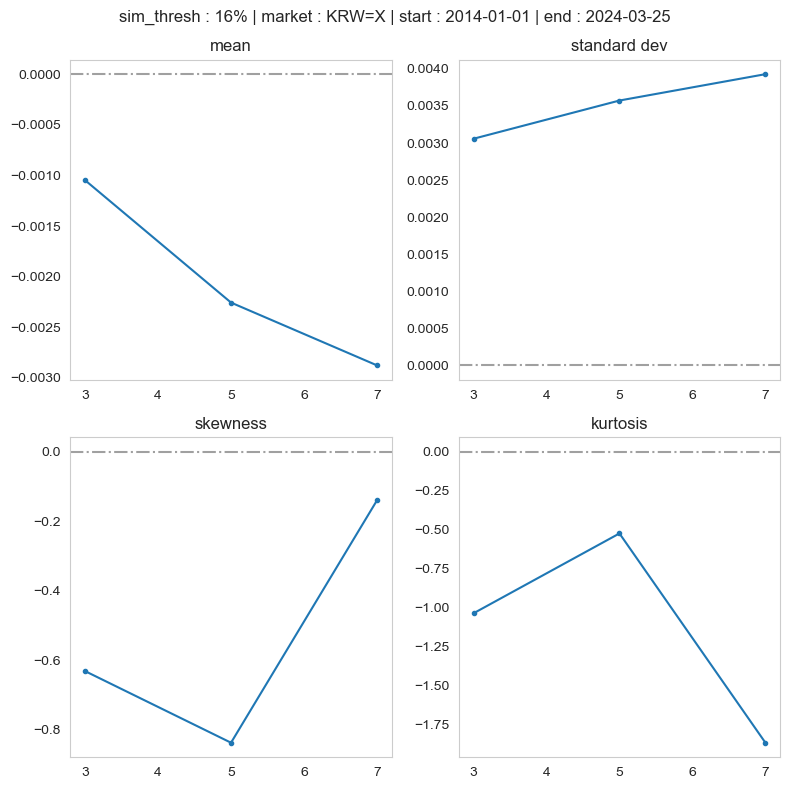

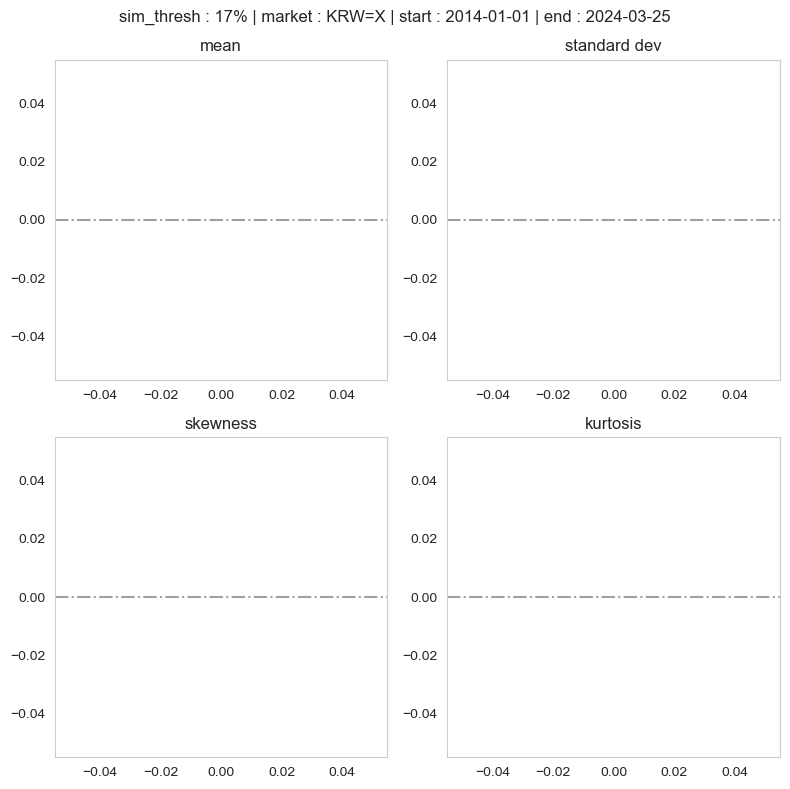

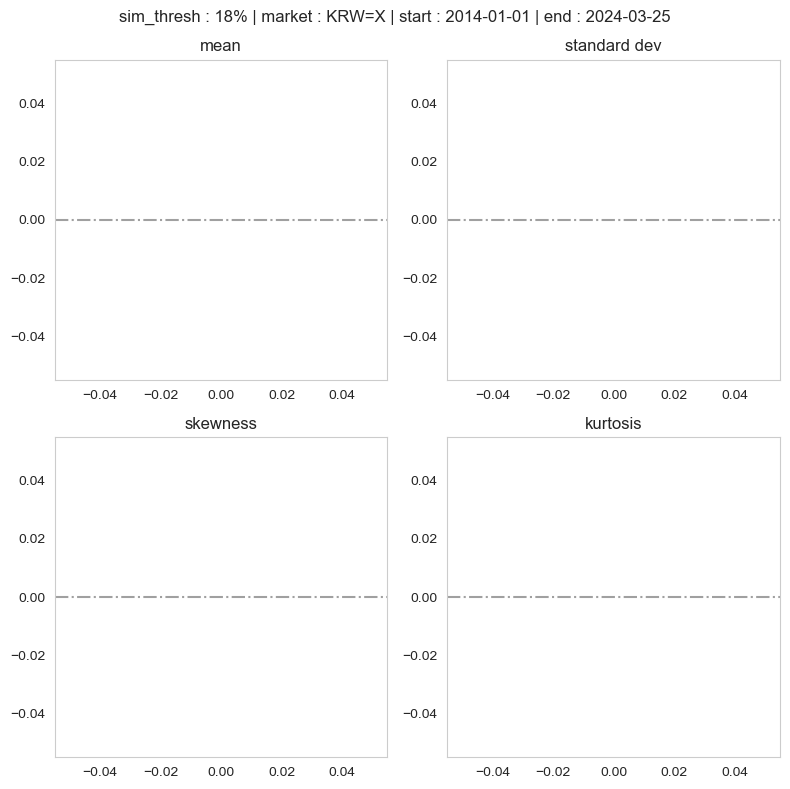

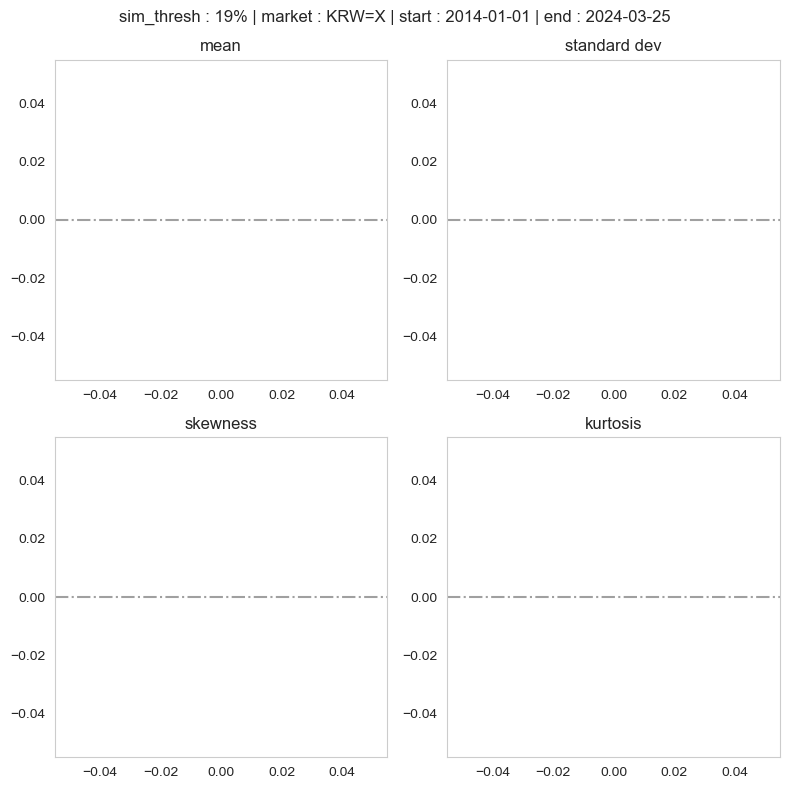

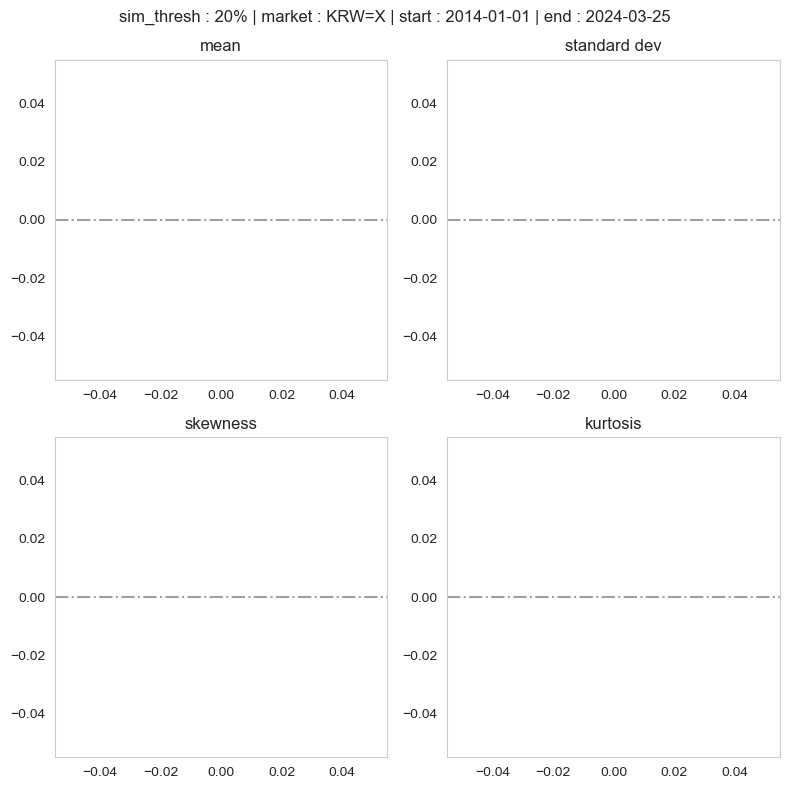

In [10]:
for tick in cumret.columns :
    for i in threshold :
        t = -i * 100
        pipeline(int(t), days, dataframes[tick], tick)

In [15]:
import pickle

with open('currency.pkl', 'wb') as f:
    pickle.dump(dataframes, f)

In [16]:
with open('currency.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)